# Transformer를 이용한 감정분석기 - 한국어 Data

원본 제작자: Park Chanjun (박찬준) <br> Email: bcj1210@naver.com<br>
원본 제작자 소속: Korea University Natural Language Processing & Artificial Intelligence Lab<br>


## Naver Sentiment Movie Corpus(NSMC) 준비

In [59]:
# 네이버 영화리뷰 감정분석 데이터 다운로드
!git clone https://github.com/e9t/nsmc.git

fatal: destination path 'nsmc' already exists and is not an empty directory.


In [60]:
# konlpy 한국어 자연어 파이썬 패키지 다운로드
# Error 발생 시, 처음에는 충돌나는 경우가 있으나, 다시 실행하면 됨
!pip install konlpy



## 데이터 전처리

In [61]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import keras

train = pd.read_csv("nsmc/ratings_train.txt", sep='\t')
test = pd.read_csv("nsmc/ratings_test.txt", sep='\t')


print(train.shape)
print(test.shape)



(150000, 3)
(50000, 3)


In [62]:
train[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [63]:
test[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [64]:
# https://wikidocs.net/44249 블로그 참조해서 전처리해줌

# 전처리에서는 학습에 영향을 끼칠 수 있는 좋지않은 데이터를 제거하는 것이 목적

train['document'].nunique(), train['label'].nunique()
test['document'].nunique(), test['label'].nunique()
#   총 150,000개의 샘플이 존재하는데 document열에서
#   중복을 제거한 샘플의 개수가 146,182개라는 것은
#   약 4,000개의 중복 샘플이 존재한다는 의미임 
#   label 열은 0 또는 1의 값만을 가지므로 결과가 두가지가 있다는 '2 가 출력됨

(49157, 2)

In [65]:
train.drop_duplicates(subset=['document'], inplace=True) 
test.drop_duplicates(subset=['document'], inplace=True) 
# document 열에서 중복인 내용이 있다면 중복 제거

In [66]:
print(train.isnull().values.any())
print(test.isnull().values.any())
# Null 값을 가진 샘플 확인

True
True


In [67]:
print(train.isnull().sum())
print(test.isnull().sum())
# 비어있는 샘플 개수 확인

id          0
document    1
label       0
dtype: int64
id          0
document    1
label       0
dtype: int64


In [69]:
train.loc[train.document.isnull()]
test.loc[test.document.isnull()]
# 어떤 것인지 한번더 확인


,id,document,label
5746,402110,NaN,1


In [70]:
train = train.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train.isnull().values.any()) # Null 값이 존재하는지 확인

test = test.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(test.isnull().values.any()) # Null 값이 존재하는지 확인

False
False


In [71]:

# 한글과 공백을 제외하고 모두 제거
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [72]:
train[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [73]:
test[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


In [74]:
train['document'].replace('', np.nan, inplace=True)
print(train.isnull().sum())

test['document'].replace('', np.nan, inplace=True)
print(test.isnull().sum())

id          0
document    0
label       0
dtype: int64
id          0
document    0
label       0
dtype: int64


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [75]:
train = train.dropna(how = 'any')
print(len(train))

test = test.dropna(how = 'any')
print(len(test))

146182
49157


In [76]:
# 불용어를 정리함
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


In [77]:

# konlpy 관련 패키지 import
from konlpy.tag import Okt
# from konlpy.tag import Kkma
# from konlpy.tag import Hannanum
# from konlpy.tag import Komoran
# from konlpy.tag import Twitter

# kkma = Kkma()
okt = Okt()
# komoran = Komoran()
# hannanum = Hannanum()
# twitter = Twitter()


# 학습용 데이터 전처리
X_train = []
for sentence in train['document']:
    temp_X1 = []
    temp_X1 = okt.morphs(sentence, stem=True) # 토큰화
    temp_X1 = [word for word in temp_X1 if not word in stopwords] # 불용어 제거
    X_train.append(temp_X1)



In [78]:
# 테스트 데이터 전처리
X_test = []
for sentence in test['document']:
    temp_X2 = []
    temp_X2 = okt.morphs(sentence, stem=True) # 토큰화
    temp_X2 = [word for word in temp_X2 if not word in stopwords] # 불용어 제거
    X_test.append(temp_X2)


In [79]:
# 정수 인코딩 처리

tokenizer = Tokenizer()

# for sentence in train['document']:
#   X_train.append([word for word in str(sentence).split(" ")]) # 원본 실습 코드
  
# for sentence in test['document']:
#   X_test.append([word for word in str(sentence).split(" ")])  # 원본 실습 코드


tokenizer.fit_on_texts(X_train) #단어 인덱스를 구축합니다.
tokenizer.fit_on_texts(X_test) #단어 인덱스를 구축합니다.

X_train = tokenizer.texts_to_sequences(X_train) #문자열을 정수 인덱스의 리스트로 변환합니다.
X_test = tokenizer.texts_to_sequences(X_test) #문자열을 정수 인덱스의 리스트로 변환합니다.

maxlen = 128  
vocab_size = len(tokenizer.word_index)+1 # 단어의 수

X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)#패딩
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)#패딩

labels_train = train['label'].values
labels_test = test['label'].values

## Transformer 모델

In [80]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) #Multihead Attn 블록
        attn_output = self.dropout1(attn_output, training=training) #드롭아웃
        out1 = self.layernorm1(inputs + attn_output) #LM + Residual
        ffn_output = self.ffn(out1) #FF 블록
        ffn_output = self.dropout2(ffn_output, training=training) #드롭아웃
        return self.layernorm2(out1 + ffn_output) #LM + Residual

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, emded_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=emded_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=emded_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1) #포지션 정보
        positions = self.pos_emb(positions) #포지션 임베딩
        x = self.token_emb(x) #토큰임베딩
        return x + positions #합치기

In [81]:
embed_dim = 32  # Embedding size for each token # modify 32, 512
num_heads = 2  # Number of attention heads # modify 8, 2
ff_dim = 32  # Hidden layer size in feed forward network inside transformer # modify 32, 2048

inputs = layers.Input(shape=(maxlen,)) #처음 입력
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim) #객체 생성
x = embedding_layer(inputs)  #포지셔널 임베딩
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim) #객체 생성
x = transformer_block(x) #트랜스포머 
x = layers.GlobalAveragePooling1D()(x) #Average Pooling
x = layers.Dropout(0.1)(x) #드롯아웃
x = layers.Dense(20, activation="relu")(x) #FFNN
x = layers.Dropout(0.1)(x) #드롭아웃
outputs = layers.Dense(2, activation="softmax")(x) #Softmax

model = keras.Model(inputs=inputs, outputs=outputs) #모델 생성

## 학습

In [82]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    X_train, labels_train, batch_size=32, epochs=3, validation_split=0.2
)

Epoch 1/3
3655/3655 [==============================] - 68s 18ms/step - loss: 0.5050 - accuracy: 0.7155 - val_loss: 0.3671 - val_accuracy: 0.8347
Epoch 2/3
3655/3655 [==============================] - 64s 17ms/step - loss: 0.3185 - accuracy: 0.8628 - val_loss: 0.3631 - val_accuracy: 0.8402
Epoch 3/3
3655/3655 [==============================] - 62s 17ms/step - loss: 0.2764 - accuracy: 0.8824 - val_loss: 0.3720 - val_accuracy: 0.8421


## 성능 측정

In [83]:
#모델 정보 출력
model.summary() 

#성능 측정 의미없음
test_loss,test_acc=model.evaluate(X_test,labels_test)
print("Test_acc: ",test_acc)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
token_and_position_embedding (None, 128, 32)           1566848   
_________________________________________________________________
transformer_block (Transform (None, 128, 32)           6464      
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                660       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0     

In [84]:
# 캐글용 데이터 전처리 작업


exam = pd.read_csv("/content/ko_data_UTF8.txt", sep='\t')

print(exam.shape)

# 캐글 대회용 데이터의 열 index명칭이 달라서 수정필요
exam = exam.rename(columns={'Sentence':'document'})

# 캐글 대회용 데이터에는 label 열이 없으므로, 열추가해서 값 초기화 적용.
exam['label'] = 0
print(exam.shape)


(11187, 2)
(11187, 3)


In [85]:
exam[:5]

,Id,document,label
0,0,정말 많이 울었던 영화입니다.,0
1,1,시간 낭비예요.,0
2,2,포스터를 저렇게밖에 만들지 못했던 제작자의 소심함에 침을 뱉고 싶다.,0
3,3,지금 봐도 재미있는 영화!!! 코믹과 감동!!! 그리고 요리!!!,0
4,4,이걸 영화로 만드는 거야?얼마나 가는지 보자.,0


In [86]:
# 한글과 공백을 제외하고 모두 제거
exam['document'] = exam['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")

In [87]:
exam[:5]

,Id,document,label
0,0,정말 많이 울었던 영화입니다,0
1,1,시간 낭비예요,0
2,2,포스터를 저렇게밖에 만들지 못했던 제작자의 소심함에 침을 뱉고 싶다,0
3,3,지금 봐도 재미있는 영화 코믹과 감동 그리고 요리,0
4,4,이걸 영화로 만드는 거야 얼마나 가는지 보자,0


In [88]:
# 캐글 대회용 데이터 전처리
X_exam = []
for sentence in exam['document']:
    temp_X3 = []
    temp_X3 = okt.morphs(sentence, stem=True) # 토큰화
    temp_X3 = [word for word in temp_X3 if not word in stopwords] # 불용어 제거
    X_exam.append(temp_X3)

In [93]:
# 정수 인코딩 처리

tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_exam) #단어 인덱스를 구축합니다.

X_exam = tokenizer.texts_to_sequences(X_exam) #문자열을 정수 인덱스의 리스트로 변환합니다.

maxlen = 128  
vocab_size = len(tokenizer.word_index)+1 # 단어의 수

X_exam = keras.preprocessing.sequence.pad_sequences(X_exam, maxlen=maxlen)#패딩

labels_exam = X_exam['label'].values




# tokenizer = Tokenizer()

# # for sentence in train['document']:
# #   X_train.append([word for word in str(sentence).split(" ")]) # 원본 실습 코드
  
# # for sentence in test['document']:
# #   X_test.append([word for word in str(sentence).split(" ")])  # 원본 실습 코드


# tokenizer.fit_on_texts(X_train) #단어 인덱스를 구축합니다.
# tokenizer.fit_on_texts(X_test) #단어 인덱스를 구축합니다.

# X_train = tokenizer.texts_to_sequences(X_train) #문자열을 정수 인덱스의 리스트로 변환합니다.
# X_test = tokenizer.texts_to_sequences(X_test) #문자열을 정수 인덱스의 리스트로 변환합니다.

# maxlen = 128  
# vocab_size = len(tokenizer.word_index)+1 # 단어의 수

# X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)#패딩
# X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)#패딩

# labels_train = train['label'].values
# labels_test = test['label'].values

AttributeError: ignored

In [94]:
model.predict(X_exam)

array([[0.0259018 , 0.97409815],
       [0.17396785, 0.8260321 ],
       [0.68486196, 0.315138  ],
       ...,
       [0.04882909, 0.95117086],
       [0.6101536 , 0.38984638],
       [0.7330734 , 0.26692662]], dtype=float32)

In [97]:
# model.add(layers.Dense(1,activation='sigmoid'))
result = 1 - model.predict(X_exam)

result2 = result.round(0).astype(int) # 결과를 정수값으로 변환
# result2 = np.argmax(result)

submission1 = pd.DataFrame({'Id':exam['Id']}) 
submission1['Predicted']= 0
submission1['Predicted']= result

print(submission1.head(10))

   Id  Predicted
0   0   0.974098
1   1   0.826032
2   2   0.315138
3   3   0.020369
4   4   0.022996
5   5   0.803183
6   6   0.173351
7   7   0.276286
8   8   0.394862
9   9   0.416472


In [101]:
submission = pd.DataFrame({'Id':exam['Id']}) 
submission['Predicted']= 0
submission['Predicted']= result2

print(submission.head(10))

print(submission['Predicted'].value_counts())

import datetime
timestring = datetime.datetime.now().strftime('Submission_%Y-%m-%d_%H:%M:%S')
filename = f'{timestring}.csv'
print(filename)
print(submission.to_csv(filename, index=False))

   Id  Predicted
0   0          1
1   1          1
2   2          0
3   3          0
4   4          0
5   5          1
6   6          0
7   7          0
8   8          0
9   9          0
0    5912
1    5275
Name: Predicted, dtype: int64
Submission_2020-12-25_08:01:19.csv
None


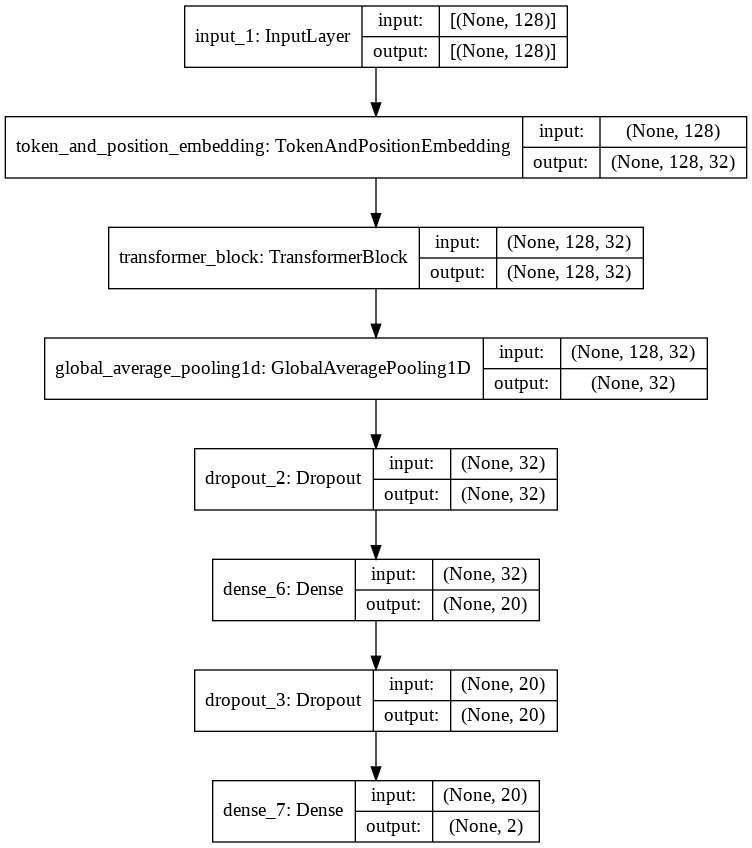

In [102]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
while True:pass